# Sustav za analizu društvenih mreža


# Čitanje datoteka

In [23]:
def convert_circles_to_prolog(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            #prazne linije
            line = line.strip()
            if not line:
                continue  
            
            if '\t' in line:  
                parts = line.split("\t")
            elif ':' in line:  
                parts = line.split(":")
                parts[1] = parts[1].replace(",", " ")  
            else:
                raise ValueError(f"Unknown format in line: {line}")
            
            #ime kruga
            circle_label = parts[0].strip()
            #korisnici
            nodes = list(map(int, parts[1:]))
            
            #prolog zapis
            for node in nodes:
                outfile.write(f"circle_user({circle_label}, user{node}).\n")
    
    print(f"Kreirana Prolog datoteka: {output_file}")

#ulazne i izlazne putanje
input_file = '/home/karla/Desktop/TBP/facebook/0.circles'
output_file = '/home/karla/Desktop/TBP/facebook/circles.P'

convert_circles_to_prolog(input_file, output_file)

Kreirana Prolog datoteka: /home/karla/Desktop/TBP/facebook/circles.P


In [17]:
import os
def edges_file(directory, filename="0.edges", output_filename="edges.P"):
    edges = []
    file_path = os.path.join(directory, filename)
    
    # čitanje 0.edges datoteke
    with open(file_path, 'r') as file:
        for line in file:
            nodes = line.strip().split()  
            if len(nodes) == 2:
                node1, node2 = map(int, nodes)  
                edges.append((node1, node2))  
    
    # spremanje u .P format
    output_path = os.path.join(directory, output_filename)
    with open(output_path, 'w') as output_file:
        for node1, node2 in edges:
            output_file.write(f"edge({node1}, {node2}).\n")
    
    print(f"Spremljeno na putanji: {output_path}")
    return edges

directory = '/home/karla/Desktop/TBP/facebook'
edges = edges_file(directory, "0.edges", "edges.P")


Spremljeno na putanji: /home/karla/Desktop/TBP/facebook/edges.P


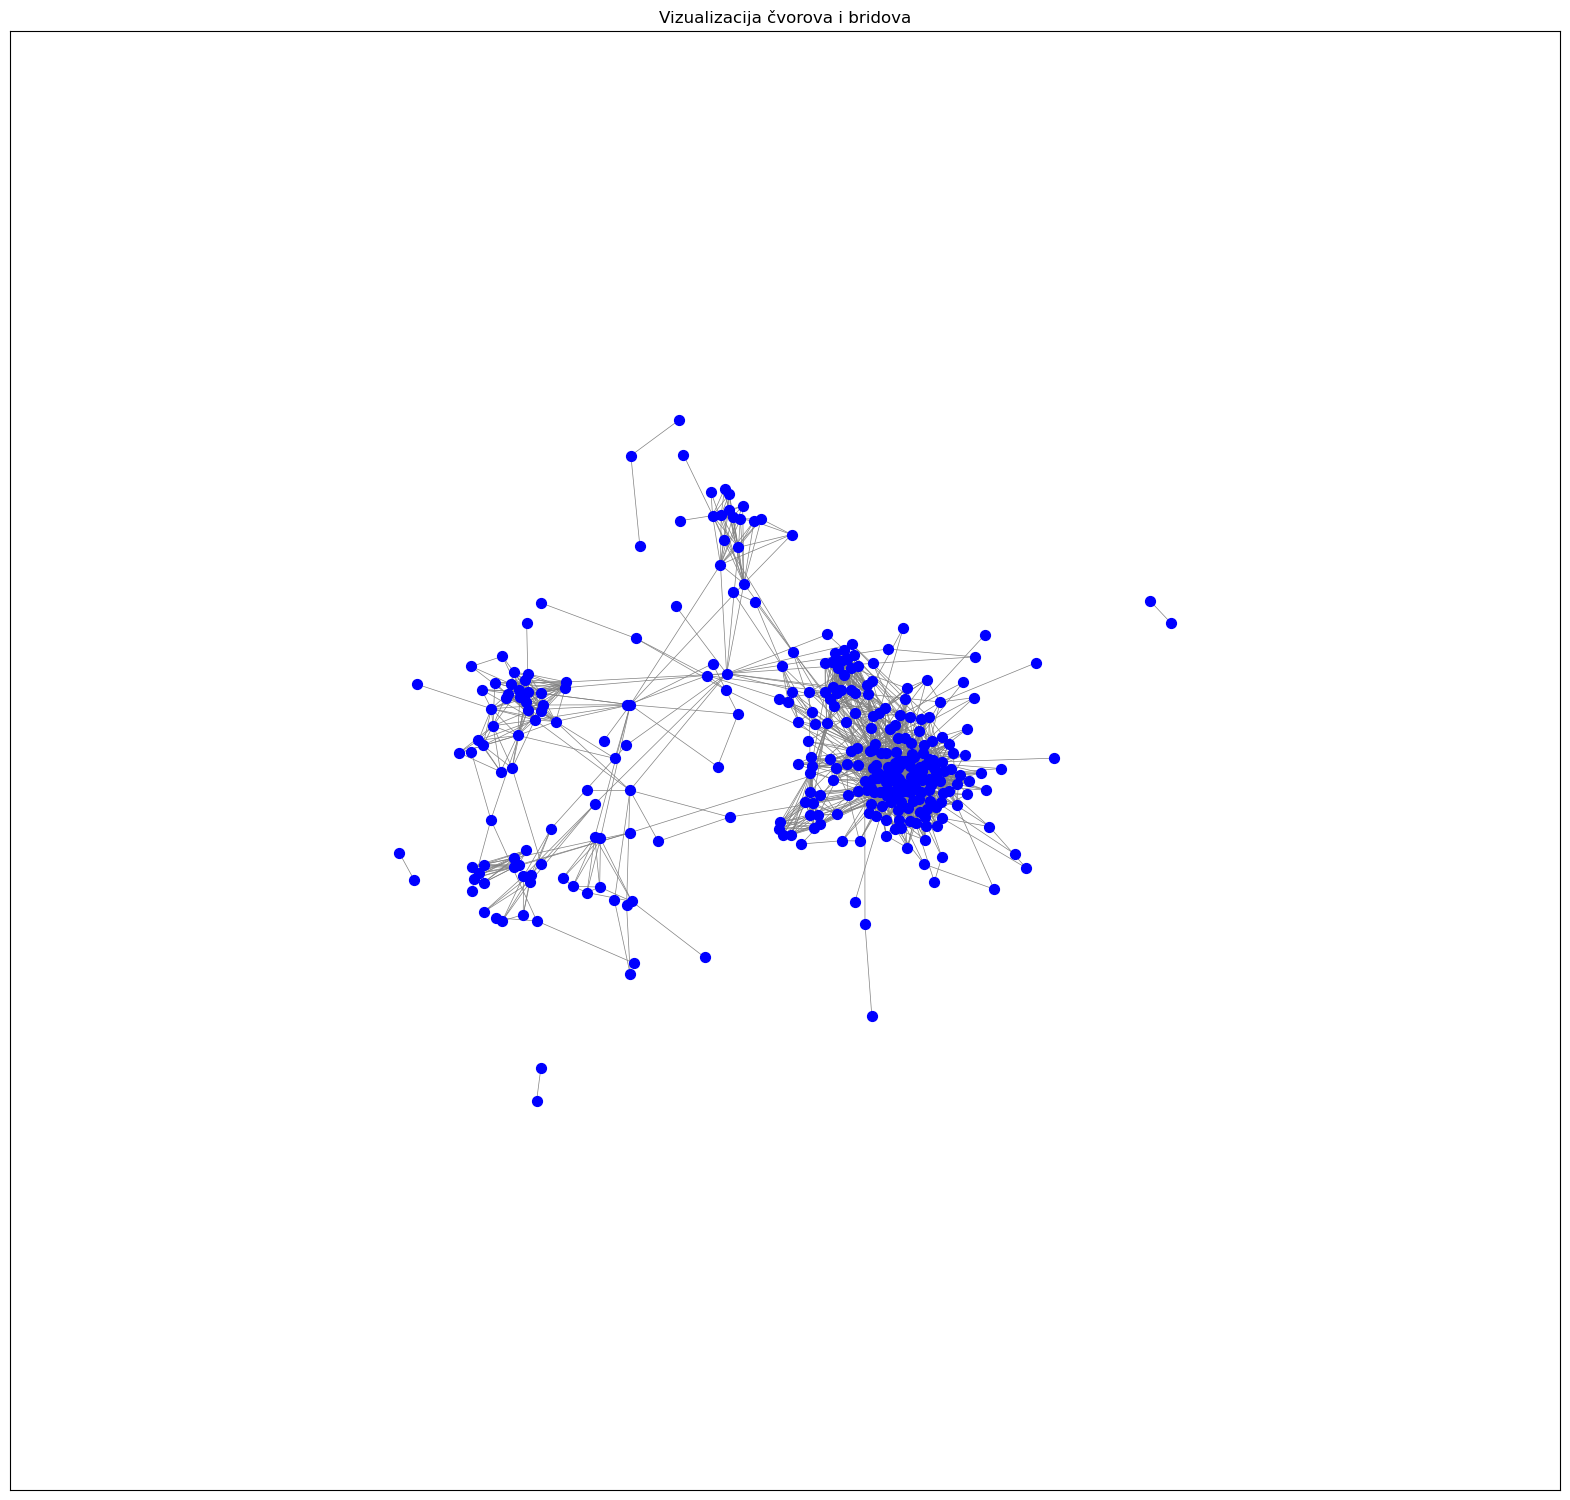

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(20, 20))  
ax = plt.gca()

pos = nx.spring_layout(G, seed=42, k=0.15)  

#crtanje bridova
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='gray', width=0.5)

#crtanje čvorova
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=50, node_color='blue')


plt.xlim(min([p[0] for p in pos.values()]) - 1, max([p[0] for p in pos.values()]) + 1)
plt.ylim(min([p[1] for p in pos.values()]) - 1, max([p[1] for p in pos.values()]) + 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Vizualizacija čvorova i bridova")


output_image_path = os.path.join(directory, "graph_image.png")
plt.savefig(output_image_path)
plt.show()

In [61]:
feat_path = '/home/karla/Desktop/TBP/facebook/0.feat'
featnames_path = '/home/karla/Desktop/TBP/facebook/0.featnames'

# čitanje .feat datoteke
with open(feat_path, 'r') as feat_file:
    feat_data = [line.strip().split() for line in feat_file]

# čitanje .featnames datoteke
with open(featnames_path, 'r') as featnames_file:
    featnames_data = [line.strip() for line in featnames_file]


feature_map = {index: name.split(' ', 1)[1] for index, name in enumerate(featnames_data)}
feature_to_nodes = {feature_map[i]: [] for i in range(len(featnames_data))}


for line in feat_data:
    node_id = line[0]
    features = line[1:]
    for i, value in enumerate(features):
        if value == '1':  
            feature_to_nodes[feature_map[i]].append(node_id)


#filtriranje značajki koje nemaju nijedan čvor vezan za sebe
filtered_feature_to_nodes = {feature: nodes for feature, nodes in feature_to_nodes.items() if nodes}

# spremanje u .P formatu
output_path = '/home/karla/Desktop/TBP/facebook/features_with_nodes.P'
with open(output_path, 'w') as output_file:
    for feature, nodes in filtered_feature_to_nodes.items():
        for node_id in nodes:
            output_file.write(f"feature(user{node_id}, '{feature}').\n")

print(f"Kreirano na putanji: {output_path}")

Kreirano na putanji: /home/karla/Desktop/TBP/facebook/features_with_nodes.P


# pyxf XSB

In [84]:
from pyxf.pyxf import xsb
import ast

# Pokretanje XSB engine
engine = xsb(path='/home/karla/software/Flora-2/XSB/bin/xsb')

# Učitavanje .P datoteka
engine.query("consult('/home/karla/Desktop/TBP/facebook/edges.P').")
engine.query("consult('/home/karla/Desktop/TBP/facebook/rules.P').")
engine.query("consult('/home/karla/Desktop/TBP/facebook/features_with_nodes.P').")
engine.query("consult('/home/karla/Desktop/TBP/facebook/circles.P').")

result = engine.query("top_influential(10, TopNodes).")


top_nodes_str = result[0]['TopNodes']

# Parsiranje stringa u stvarnu listu 
top_nodes = ast.literal_eval(top_nodes_str)

print("Najutjecajniji čvorovi su:")
counter=1
for i in top_nodes:
    print(f"{counter}. {i[0]}")
    counter += 1
 


Najutjecajniji čvorovi su:
1. 56
2. 67
3. 271
4. 322
5. 25
6. 26
7. 21
8. 252
9. 277
10. 122


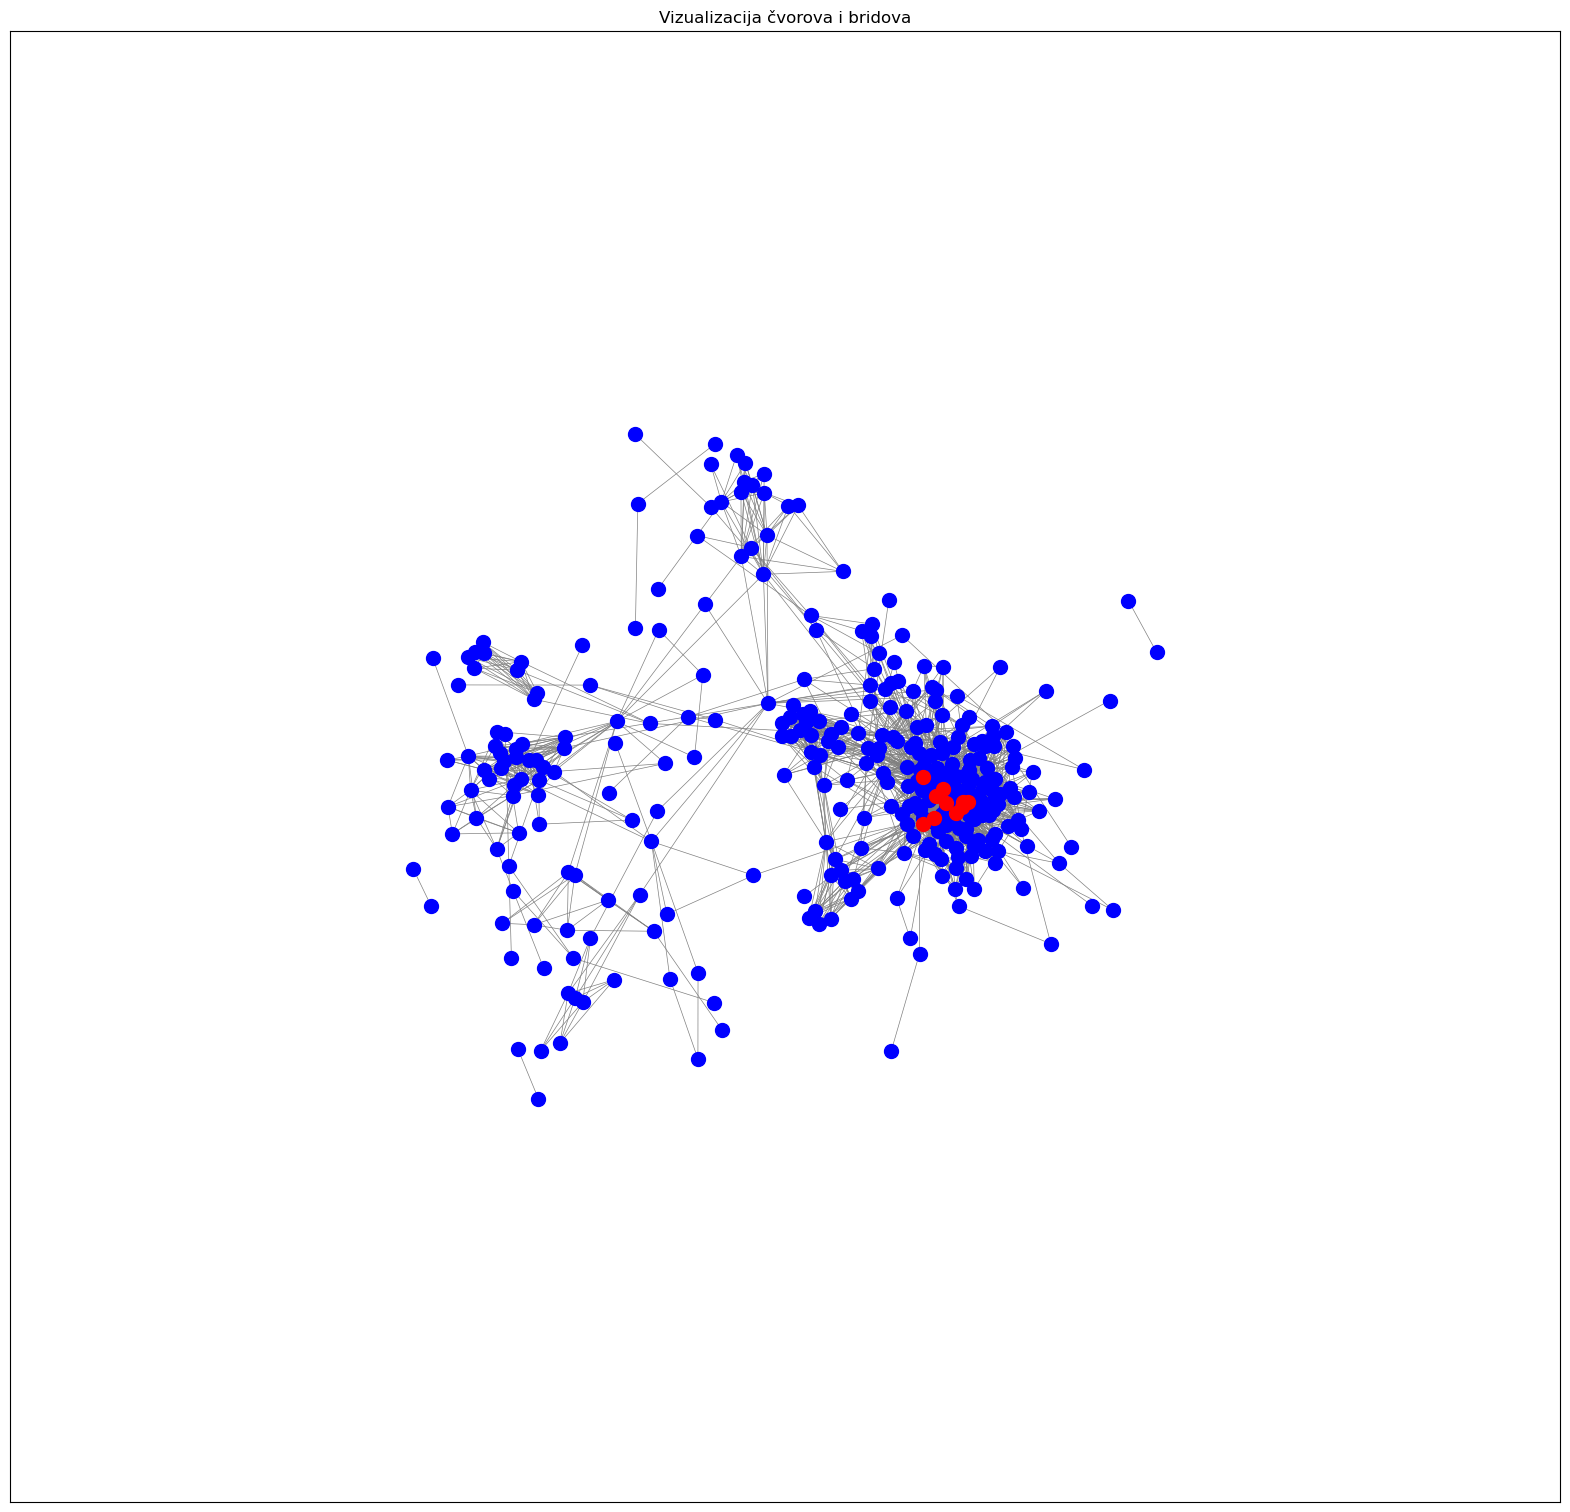

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

edges = []
with open('/home/karla/Desktop/TBP/facebook/0.edges', 'r') as file:
    for line in file:
        nodes = line.strip().split()  
        if len(nodes) == 2:
            node1, node2 = map(int, nodes)  
            edges.append((node1, node2))  

#kreiranje grafa
G = nx.Graph()
G.add_edges_from(edges)

#definiranje najutjecajnijih čvorova
top_nodes_set = {node[0] for node in top_nodes}

plt.figure(figsize=(20, 20))
ax = plt.gca()


pos = nx.spring_layout(G, seed=42, k=0.20)  

#crtanje bridova
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='gray', width=0.5)

#plavi čvorovi
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=100, node_color='blue',
                       nodelist=[node for node in G.nodes if node not in top_nodes_set])

#crveni čvorovi
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=100, node_color='red',
                       nodelist=[node for node in G.nodes if node in top_nodes_set])


plt.xlim(min([p[0] for p in pos.values()]) - 1, max([p[0] for p in pos.values()]) + 1)
plt.ylim(min([p[1] for p in pos.values()]) - 1, max([p[1] for p in pos.values()]) + 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Vizualizacija čvorova i bridova")

output_image_path = '/home/karla/Desktop/TBP/facebook/graph_with_top_nodes.png'
plt.savefig(output_image_path)

plt.show()

In [59]:
import networkx as nx
from pyxf.pyxf import xsb
import ast

# Pokretanje XSB engine
engine = xsb(path='/home/karla/software/Flora-2/XSB/bin/xsb')

# Učitavanje .P datoteka
engine.query("consult('/home/karla/Desktop/TBP/facebook/edges.P').")
engine.query("consult('/home/karla/Desktop/TBP/facebook/rules.P').")
engine.query("consult('/home/karla/Desktop/TBP/facebook/features_with_nodes.P').")
#engine.query("consult('/home/karla/Desktop/TBP/facebook/circles.P').")

result = engine.query("top_influential(10, TopNodes).")
top_nodes_str = result[0]['TopNodes']

# Parsiranje stringa u stvarnu listu
top_nodes = ast.literal_eval(top_nodes_str)

print("Klasteri za top 10 najutjecajnijih čvorova su:")
clusters = {}  
for node in top_nodes[:10]:
    cluster_result = engine.query(f"cluster({node[0]}, Cluster).") 
    if cluster_result:
        cluster = cluster_result[0]['Cluster']
        clusters[node[0]] = cluster
        print(f"\nKlaster za čvor {node[0]}:")
        print(cluster)







Klasteri za top 10 najutjecajnijih čvorova su:

Klaster za čvor 56:
[67,26,88,141,185,128,297,239,252,103,132,55,75,66,119,161,62,332,272,221,169,59,203,122,238,9,334,136,298,60,212,30,199,222,313,211,277,231,342,72,40,290,276,322,104,291,304,188,200,21,303,170,186,325,109,331,232,265,118,213,82,261,134|...]

Klaster za čvor 67:
[141,69,142,55,297,136,203,212,290,188,123,119,75,186,109,272,62,345,9,323,196,200,332,252,325,271,26,280,128,104,213,13,277,344,72,21,134,322,25,304,265,303,3,185,10,313,223,239,56,169,236,308,324,248,285,45,113,170,31,66,315,40,118|...]

Klaster za čvor 271:
[304,252,188,30,232,203,133,79,21,172,332,25,276,322,277,141,142,331,119,170,236,185,199,176,40,285,239,261,211,297,59,128,272,325,265,9,315,113,13,26,290,224,148,169,291,103,223,318,323,48,342,82,109,238,212,268,280,122,72,313,161,186,85|...]

Klaster za čvor 322:
[53,122,25,290,48,203,45,136,56,60,1,130,161,85,323,128,118,246,62,88,308,21,9,276,158,257,75,242,329,104,250,339,252,30,345,170,178,109,26,18